In [2]:
import pandas as pd
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.lines import Line2D
import os
import scanpy as sc
import numpy as np
import torch
import random

import sys
sys.path.append(os.path.abspath("../"))
from metrics import spearman_score, pearson_score, root_mean_square_error, mean_square_error
from utils import random_splits

from scipy.stats import rankdata
from sklearn.metrics import roc_curve, auc

import scanpy as sc
import anndata

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as editable Type 1 fonts
plt.rcParams['ps.fonttype'] = 42   # For EPS compatibility

warnings.simplefilter(action="ignore", category=Warning)

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

fix_seed(42)

dir_path = '/ewsc/wuqitian/lung_preprocess'
meta_info = pd.read_csv("../../data/meta_info_lung.csv")
    
def negative_sample_idx(y, pos_ratio=0.5, neg_times=5):
    idx = torch.arange(0, y.shape[0])
    pos_idx = idx[y == 1]
    sample_pos_idx_ = torch.as_tensor(np.random.permutation(pos_idx.shape[0]))[:int(pos_ratio*pos_idx.shape[0])]
    sample_pos_idx = pos_idx[sample_pos_idx_]
    
    neg_idx = idx[y == 0]
    sample_neg_idx_ = torch.as_tensor(np.random.permutation(neg_idx.shape[0]))[:neg_times*sample_pos_idx.shape[0]]
    sample_neg_idx = neg_idx[sample_neg_idx_]
    new_idx = np.concatenate([sample_pos_idx, sample_neg_idx], axis=0)
    return new_idx

def compute_score_mean_std(y_true, y_pred, num=5, pos_ratio=0.5, neg_times=5):
    scores = []
    for n in range(num):
        idx = negative_sample_idx(y_true)
        y_true_n, y_pred_n = y_true[idx], y_pred[idx]
        fpr, tpr, _ = roc_curve(y_true_n, y_pred_n)
        roc_auc = auc(fpr, tpr)
        scores += [roc_auc]
    return np.mean(scores), np.std(scores)

def softmax(x):
    x_max = np.max(x)
    x = x - x_max
    return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(x):
    x = np.clip(x, 1e-15, 1 - 1e-15)
    return np.log(np.divide(x, 1 - x))

def logit_inv(x):
    return 1 / (1 + np.exp(-x))
    
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-5)

/local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


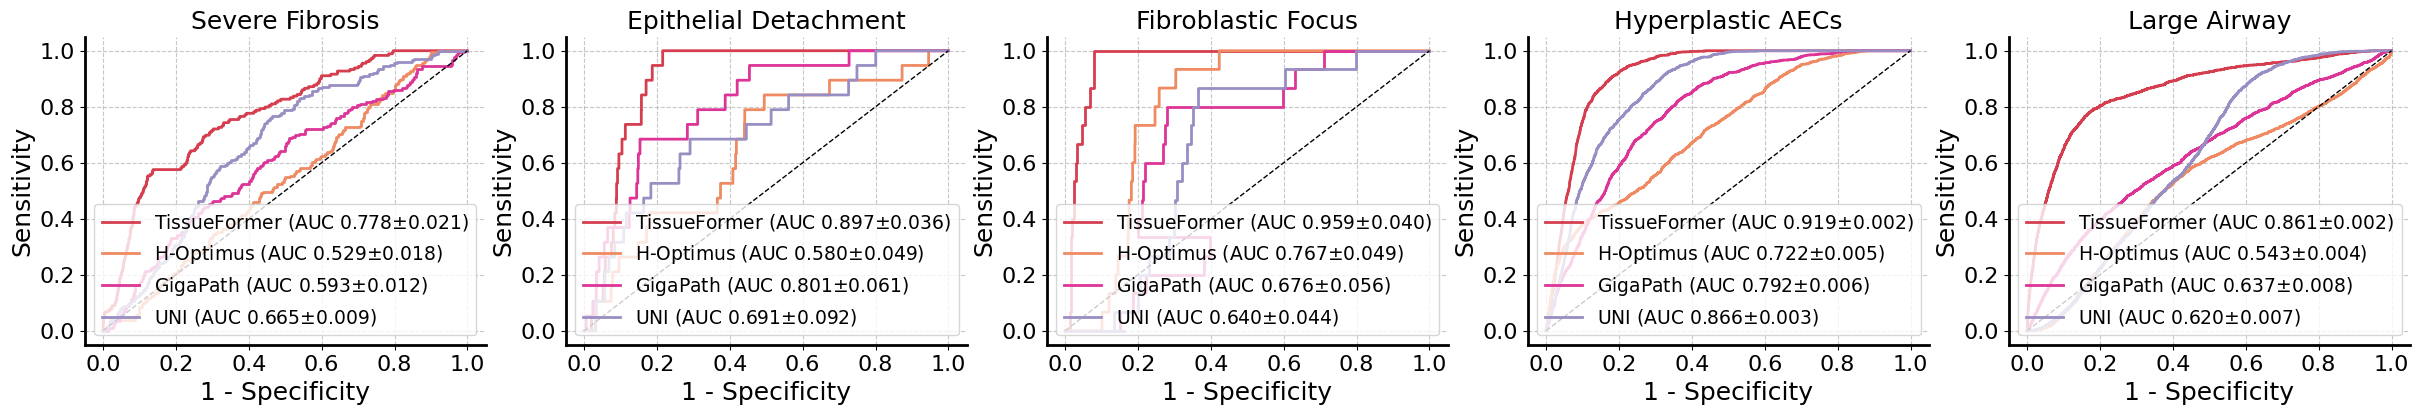

In [3]:
result_path = '/ewsc/wuqitian/analysis_pred_data/he_annotation_classification/'
tasks1=['severe_fibrosis', 'epithelial_detachment', 'fibroblastic_focus', 'hyperplastic_aec', 'large_airway']
task_names1 = ['Severe Fibrosis', 'Epithelial Detachment', 'Fibroblastic Focus', 'Hyperplastic AECs', 'Large Airway']

keys = ['ours-MLP', 'hoptimus-MLP', 'gigapath-MLP', 'uni-MLP']
methods = ['TissueFormer', 'H-Optimus', 'GigaPath', 'UNI']
colors = ['#d53e4f', '#ef8a62', '#dd3497', '#998ec3']

def plot_roc_auc_curves(tasks, task_names):
    fig, axes = plt.subplots(1, 5, figsize=(30, 4), gridspec_kw={'wspace': 0.2})
    axes = axes.flatten()
    for i, (task, task_name) in enumerate(zip(tasks, task_names)):
        ax = axes[i]
        file_path = result_path + f'{task}_true.npy'
        y_true = np.load(file_path)

        for m, (key, method) in enumerate(zip(keys, methods)):
            
            file_path = result_path + f'{task}_{key}.npy'
            y_pred = np.load(file_path)
            y_pred = y_pred[:, 1]

            fpr, tpr, _ = roc_curve(y_true, y_pred)

            auc_mean, auc_std = compute_score_mean_std(y_true, y_pred, pos_ratio=1., neg_times=3)

            ax.plot(fpr, tpr, label=rf'{method} (AUC {auc_mean:.3f}$\pm${auc_std:.3f})', color=colors[m], linewidth=2.0)

        ax.legend(loc='lower left', fontsize=13.5, ncols=1)
        ax.set_title(f'{task_name}', fontsize=18)
        ax.set_xlabel(f'1 - Specificity', fontsize=18)
        ax.set_ylabel(f'Sensitivity', fontsize=18)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.plot([0, 1], [0, 1], color="k", linestyle="--", linewidth=1)

        ax.grid(axis='x', linestyle='--', alpha=0.7)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)

plot_roc_auc_curves(tasks1, task_names1)

plt.tight_layout()
plt.savefig('../../figure/pred_lung_patho_auc_curve1.pdf')
plt.show()

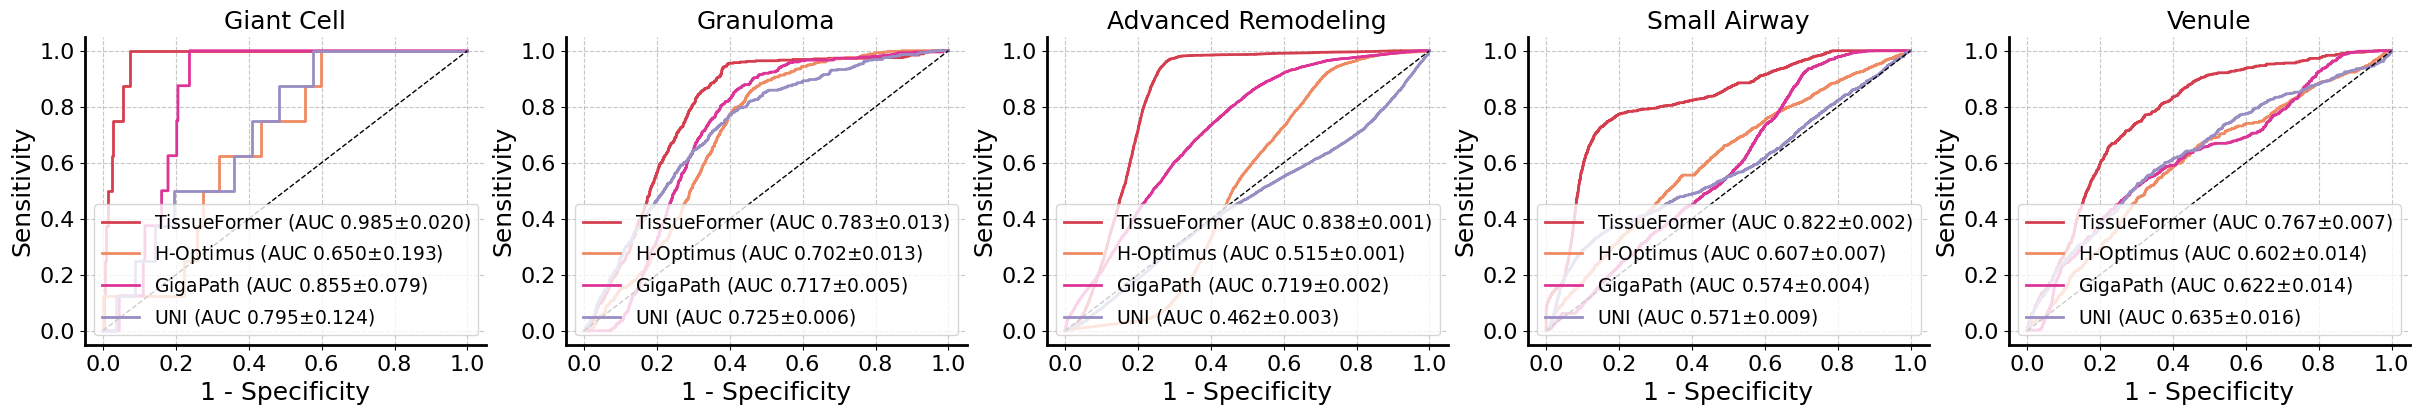

In [4]:
result_path = '/ewsc/wuqitian/analysis_pred_data/he_annotation_classification/'
tasks1=['giant_cell', 'granuloma', 'advanced_remodeling', 'small_airway', 'venule']
task_names1 = ['Giant Cell', 'Granuloma', 'Advanced Remodeling', 'Small Airway', 'Venule']

keys = ['ours-MLP', 'hoptimus-MLP', 'gigapath-MLP', 'uni-MLP']
methods = ['TissueFormer', 'H-Optimus', 'GigaPath', 'UNI']
colors = ['#d53e4f', '#ef8a62', '#dd3497', '#998ec3']

def plot_roc_auc_curves(tasks, task_names):
    fig, axes = plt.subplots(1, 5, figsize=(30, 4), gridspec_kw={'wspace': 0.2})
    axes = axes.flatten()
    for i, (task, task_name) in enumerate(zip(tasks, task_names)):
        ax = axes[i]
        file_path = result_path + f'{task}_true.npy'
        y_true = np.load(file_path)

        for m, (key, method) in enumerate(zip(keys, methods)):
            
            file_path = result_path + f'{task}_{key}.npy'
            y_pred = np.load(file_path)
            y_pred = y_pred[:, 1]

            fpr, tpr, _ = roc_curve(y_true, y_pred)

            auc_mean, auc_std = compute_score_mean_std(y_true, y_pred, pos_ratio=1, neg_times=3)
                    
            ax.plot(fpr, tpr, label=rf'{method} (AUC {auc_mean:.3f}$\pm${auc_std:.3f})', color=colors[m], linewidth=2.0)
                
        ax.legend(loc='lower left', fontsize=13.5, ncols=1)
        ax.set_title(f'{task_name}', fontsize=18)
        ax.set_xlabel(f'1 - Specificity', fontsize=18)
        ax.set_ylabel(f'Sensitivity', fontsize=18)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.plot([0, 1], [0, 1], color="k", linestyle="--", linewidth=1)

        ax.grid(axis='x', linestyle='--', alpha=0.7)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)

plot_roc_auc_curves(tasks1, task_names1)

plt.tight_layout()
plt.savefig('../../figure/pred_lung_patho_auc_curve2.pdf')
plt.show()

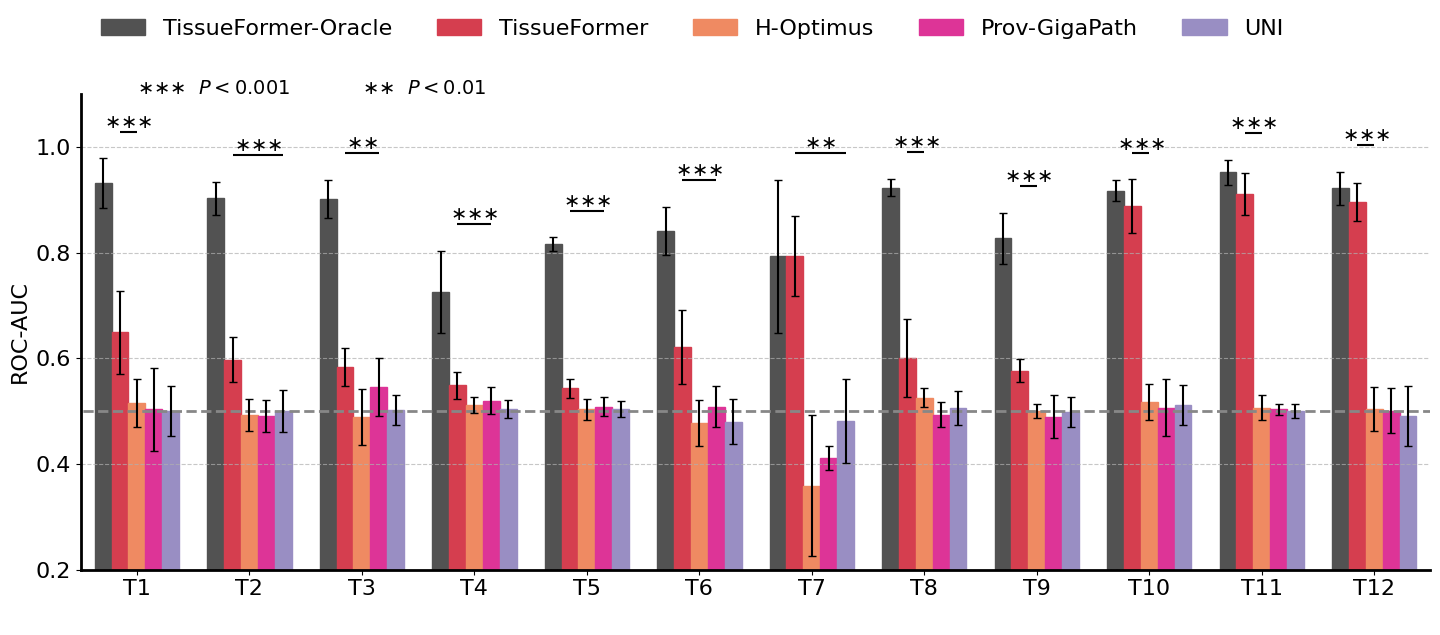

In [11]:
from sklearn.metrics import roc_auc_score
from scipy.stats import wilcoxon

result_path = '/ewsc/wuqitian/analysis_pred_data/niche_classification/'
task_names=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12']
tasks = task_names 

keys = ['ours-MLP', 'ours-MLP-pred-gene-no-image', 'hoptimus-MLP', 'gigapath-MLP', 'uni-MLP']
methods = ['TissueFormer-Oracle', 'TissueFormer', 'H-Optimus', 'Prov-GigaPath', 'UNI']
colors = ['#525252', '#d53e4f', '#ef8a62', '#dd3497', '#998ec3']

samples = ['VUILD48LA2', 'THD0008', 'VUHD113', 'VUILD91MA', 'VUILD78LA', 'VUILD102MA']
idxs = []
np.random.seed(42)
for sample in samples:
    file_path = os.path.join(dir_path, sample) + '.h5ad'
    adata = sc.read(file_path)
    num = adata.shape[0]
    idx = np.random.permutation(num)[:int(num * 0.5)]
    idxs += [idx]

evaluate_idxs = []
for task in tasks:
    offset = 0
    evaluate_idxs_i = []
    for n, sample in enumerate(samples):
        file_path = os.path.join(dir_path, sample) + '.h5ad'
        adata = sc.read(file_path)
        if (adata.obs['TNiche'][test_idxs[n]]==task).sum() > 0:
            evaluate_idxs_i += [test_idxs[n] + offset]
            offset += adata.shape[0]
    evaluate_idxs.append(evaluate_idxs_i)

handles = []
width = 0.15 
fig, ax = plt.subplots(figsize=(15, 6.5))
ax.hlines(y=0.5, xmin=-1, xmax=12, colors='#878787', linestyles='--', linewidth=2.0)

for i, (task, task_name) in enumerate(zip(tasks, task_names)):
    file_path = result_path + f'{task}_true.npy'
    y_true = np.load(file_path)
    
    bar_width = 0.75
    index = np.arange(len(methods))
    p1, p2, baseline = [], [], []
    for m, (key, method) in enumerate(zip(keys, methods)):
        file_path = result_path + f'{task}_{key}.npy'
        y_pred = np.load(file_path)
        y_pred = y_pred[:, 1]
        
        # calculate auc per sample
        aucs = []
        for evaluate_idx in evaluate_idxs[i]:
            n = evaluate_idx.shape[0]
            for k in range(5):
                idx = evaluate_idx[np.random.permutation(n)[: int(n * 0.8)]]
                y_true_n, y_pred_n = y_true[idx], y_pred[idx]
                auc_score = roc_auc_score(y_true_n, y_pred_n)
                aucs += [auc_score] if ~np.isnan(auc_score) else []
                
        auc_mean, auc_std = np.mean(aucs), np.std(aucs)

        l = ax.bar(i + m * width - (width * (len(methods) - 1) / 2), auc_mean, width, yerr=auc_std, capsize=3,
               label=f'{method}', color=colors[m], edgecolor=colors[m])
        if i==0:
            handles += [l]

        if m == 0:
            aucs_ours1 = aucs
        elif m == 1:
            aucs_ours2 = aucs
        elif m > 1:
            _, p_value1 = wilcoxon(aucs_ours1, aucs)
            _, p_value2 = wilcoxon(aucs_ours2, aucs)
            p1 += [p_value1]
            p2 += [p_value2]
            baseline += [auc_mean]
                

    x_start, x_end = i + 1 * width - (width * (len(methods) - 1) / 2), i + (np.argmax(baseline)+2) * width - (width * (len(methods) - 1) / 2)
    y_pos = np.mean(aucs_ours1) + np.std(aucs_ours1) + 0.05
    text = r'$\ast$$\ast$$\ast$' if p2[np.argmax(baseline)] < 0.001 else r'$\ast$$\ast$' if p2[np.argmax(baseline)] < 0.01 else r'$\ast$'
    ax.hlines(y=y_pos, xmin=x_start, xmax=x_end, colors='black', linestyles='-')
    ax.text((x_start + x_end) / 2, y_pos, f'{text}', ha='center', va='bottom', color='black', fontsize=14)
    

ax.set_xlabel(' ', fontsize=16)
ax.set_ylabel(f'ROC-AUC', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.set_xticks(np.arange(len(task_names)))
ax.set_xticklabels(task_names)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(0.2, 1.1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlim(-0.5, 11.5)

ax.grid(axis='x', linestyle='--', alpha=0.)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
    
ax.legend(handles, methods, loc='upper left', bbox_to_anchor=(0., 1.2), frameon=False, ncols=5, fontsize=16)
ax.text(0., 1.1, r'$\ast$$\ast$$\ast$  $P<0.001$', fontsize=14)
ax.text(2, 1.1, r'$\ast$$\ast$  $P<0.01$', fontsize=14)

plt.tight_layout()
plt.savefig('../../figure/pred_lung_niche_histogram.pdf')
plt.show()

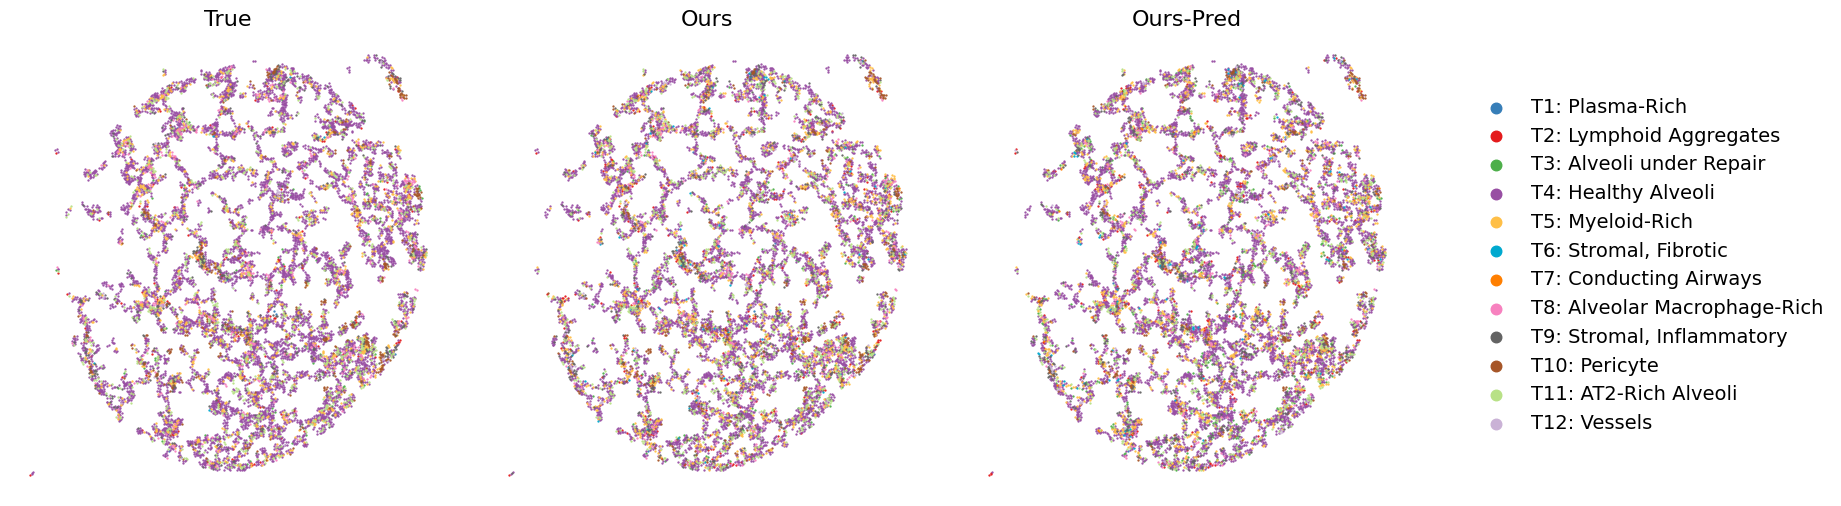

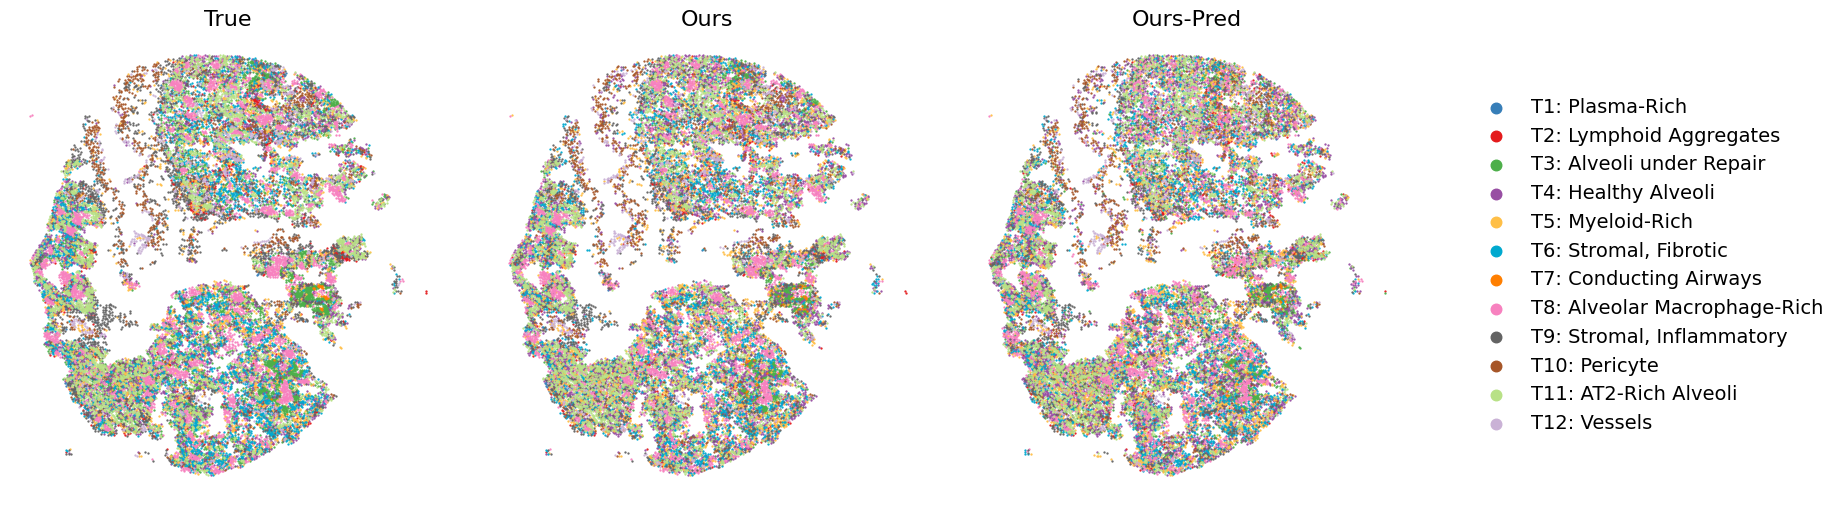

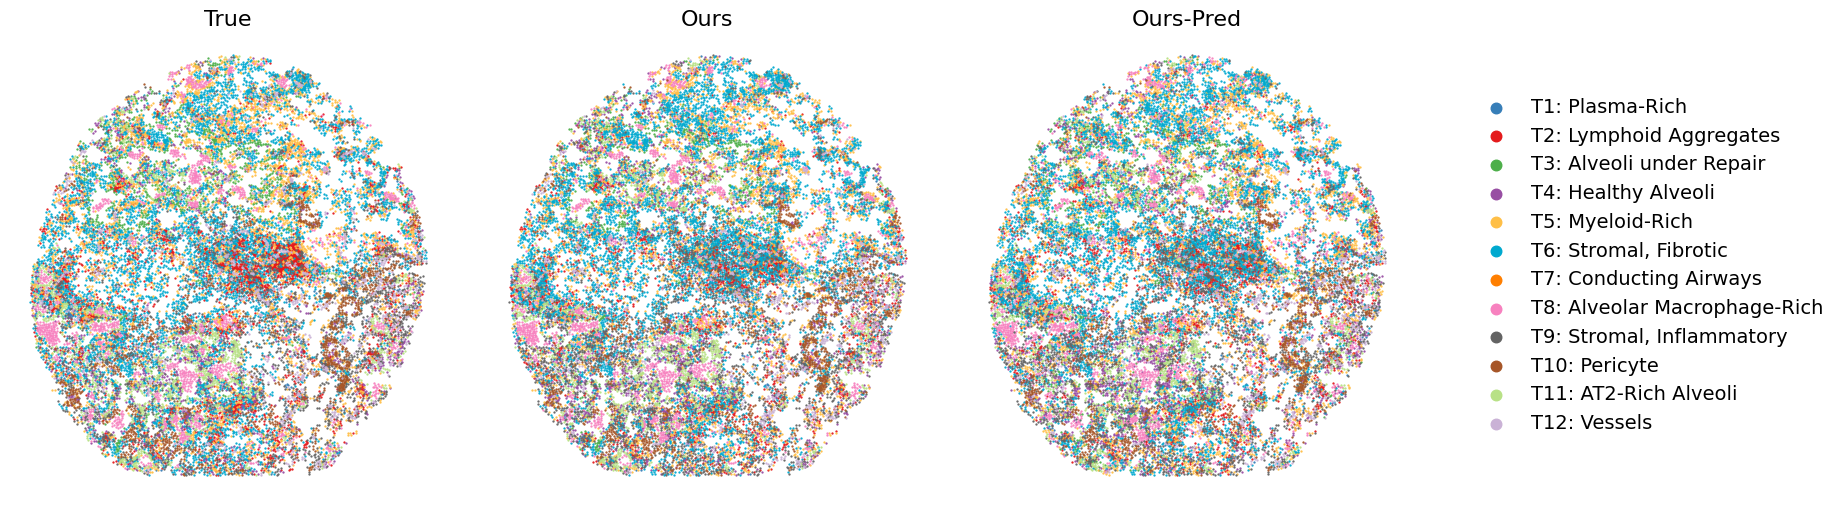

In [9]:
from sklearn.cluster import DBSCAN

result_path = '/ewsc/wuqitian/analysis_pred_data/niche_classification/'

tasks=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12']
task_names = ['Plasma-Rich', 'Lymphoid Aggregates', 'Alveoli under Repair', 'Healthy Alveoli', 'Myeloid-Rich', 'Stromal, Fibrotic',
'Conducting Airways', 'Alveolar Macrophage-Rich', 'Stromal, Inflammatory', 'Pericyte', 'AT2-Rich Alveoli', 'Vessels']
task_names = [tasks[i]+': '+tn for i, tn in enumerate(task_names)]

colors = [
    "#377EB8",  # Royal Purple
    "#E41A1C",  # Bright Red
    "#4DAF4A",  # Rich Green
    "#984EA3",  # Deep Blue
    "#FFBF47",  # Golden Yellow
    "#00A9CF",  # Turquoise
    "#FF7F00",  # Warm Orange
    "#F781BF",  # Deep Pink
    "#636363",  # Dark Gray
    "#A65628",  # Olive Green
    "#b8e186",  # Teal Blue
    "#CAB2D6"   # Soft Lavender
]

samples = ['VUILD48LA2', 'THD0008', 'VUHD113', 'VUILD91MA', 'VUILD78LA', 'VUILD102MA']

def remove_outlier_fill_hole(x, y, eps=20):
    points = np.stack([x, y], axis=1)

    # filter outlier
    clustering = DBSCAN(eps=eps, min_samples=2).fit(points)
    core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    points_filtered = points[core_samples_mask]
    x, y = points_filtered[:, 0], points_filtered[:, 1]
    # adjust to square
    x_min, x_max, y_min, y_max = x.min(), x.max(), y.min(), y.max()
    scale_x = (y_max - y_min) / (x_max - x_min)
    x = (x - x_min) * scale_x
    
    return x, y, core_samples_mask


idxs = []
for sample in samples:
    file_path = os.path.join(dir_path, sample) + '.h5ad'
    adata = sc.read(file_path)
    num = adata.shape[0]
    idxs += [np.arange(num)]
    
evaluate_idxs = []
for task in tasks:
    offset = 0
    evaluate_idxs_i = []
    for n, sample in enumerate(samples):
        file_path = os.path.join(dir_path, sample) + '.h5ad'
        adata = sc.read(file_path)
        if (adata.obs['TNiche']==task).sum() > 0:
            evaluate_idxs_i += [idxs[n] + offset]
            offset += adata.shape[0]
        else:
            evaluate_idxs_i += [None]
    evaluate_idxs.append(evaluate_idxs_i)

sample_idx = [2, 4, 3]
for sample_id in sample_idx:
    sample = samples[sample_id]
    niche_true, niche_pred, niche_pred2 = [], [], []
    for i, task in enumerate(tasks):
        evaluate_idx = evaluate_idxs[i][sample_id]
        file_path = result_path + f'{task}_true.npy'
        y_true = np.load(file_path)
    
        ct_num = y_true.sum()
    
        file_path = result_path + f'{task}_ours-MLP-no-image.npy'
        y_pred = np.load(file_path)
        y_pred = softmax(y_pred)[:, 1]
        y_pred = y_pred - np.sort(y_pred)[-ct_num]
    
        file_path = result_path + f'{task}_ours-MLP-pred-gene-no-image.npy'
        y_pred2 = np.load(file_path)
        y_pred2 = softmax(y_pred2)[:, 1]
        y_pred2 = y_pred2 - np.sort(y_pred2)[-ct_num]
        
        if evaluate_idx is None:
            niche_true += [np.zeros((niche_true[-1].shape[0],))]
            niche_pred += [np.ones((niche_true[-1].shape[0],))*-1]
            niche_pred2 += [np.ones((niche_true[-1].shape[0],))*-1]
        else:
            niche_true += [y_true[evaluate_idx]]
            niche_pred += [y_pred[evaluate_idx]]
            niche_pred2 += [y_pred2[evaluate_idx]]
    
    niche_true = np.argmax(np.stack(niche_true, axis=1), axis=1)
    niche_pred = np.argmax(np.stack(niche_pred, axis=1), axis=1)
    niche_pred2 = np.argmax(np.stack(niche_pred2, axis=1), axis=1)
        
    file_path = os.path.join(dir_path, sample) + '.h5ad'
    adata = sc.read(file_path)
    cell_centroid = adata.obsm['centroids']
    x, y = cell_centroid[:, 1], cell_centroid[:, 0]
    x, y, mask = remove_outlier_fill_hole(x, y)
    niche_true, niche_pred, niche_pred2 = niche_true[mask], niche_pred[mask], niche_pred2[mask]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'wspace': 0.1})
    axes = axes.flatten()
    
    for i, task_name in enumerate(task_names):
        
        ax = axes[0]
        mask1 = niche_true==i
        x1, y1 = x[mask1], y[mask1]
        ax.scatter(x1, y1, c=colors[i], s=0.4, label=task_name)
        ax.set_title('True', fontsize=16)
        
        ax = axes[1]
        mask2 = niche_pred==i
        x2, y2 = x[mask2], y[mask2]
        ax.scatter(x2, y2, c=colors[i], s=0.4, label=task_name)
        ax.set_title('Ours', fontsize=16)
        
        ax = axes[2]
        mask3 = niche_pred2==i
        x3, y3 = x[mask3], y[mask3]
        ax.scatter(x3, y3, c=colors[i], s=0.4, label=task_name)
        ax.set_title('Ours-Pred', fontsize=16)
        
    
    axes[0].axis('off') 
    axes[0].grid(False)
    axes[1].axis('off') 
    axes[1].grid(False)
    axes[2].axis('off')
    axes[2].grid(False)
    axes[2].legend(loc='upper right', bbox_to_anchor=(2, 0.9), frameon=False, ncols=1, fontsize=14, markerscale=12)
    
    plt.tight_layout()
    # plt.savefig(f'../../figure/pred_lung_niche_demo{sample_id}.pdf')
    plt.show()

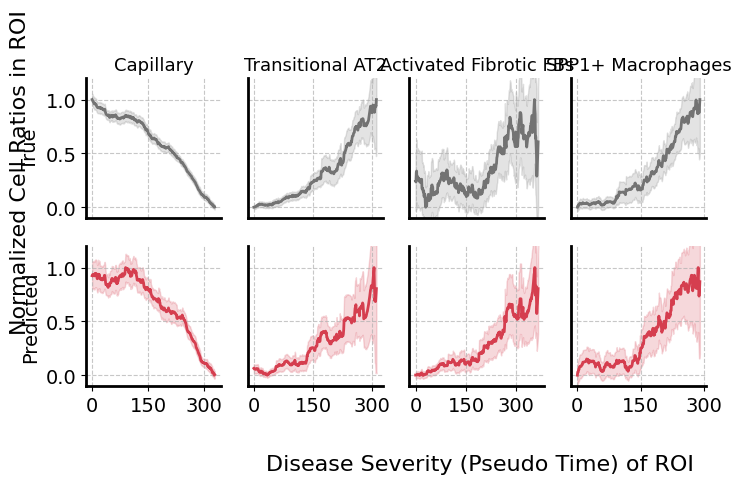

In [17]:
from patsy import dmatrix
import statsmodels.api as sm
from scipy import stats
from pygam import LinearGAM, s
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def compute_confidence_intervals(data):
    mean = np.mean(data)
    sem = stats.sem(data)
    alpha = 0.1
    df = len(data) - 1
    t_critical = stats.t.ppf(1 - alpha/2, df)
    margin_error = t_critical * sem
    return margin_error

cell_type = ['RASC', 'Secretory', 'Multiciliated', 'PNEC', 'Basal', 'Goblet', 'Proliferating Airway', 'AT2',
            'Transitional AT2', 'AT1', 'KRT5-/KRT17+', 'Proliferating AT2', 'Langerhans cells', 'NK/NKT', 'Tregs', 'CD4+ T-cells',
            'CD8+ T-cells', 'Proliferating T-cells', 'B cells', 'Plasma', 'pDCs', 'Proliferating NK/NKT', 'Proliferating B cells',
            'cDCs', 'Mast', 'Interstitial Macrophages', 'Alveolar Macrophages', 'SPP1+ Macrophages', 'Neutrophils', 'Proliferating Myeloid',
            'Migratory DCs', 'Macrophages - IFN-activated', 'Monocytes/MDMs', 'Basophils', 'Venous', 'Capillary', 'Lymphatic',
            'Arteriole', 'SMCs/Pericytes', 'Alveolar FBs', 'Proliferating FBs', 'Inflammatory FBs', 'Activated Fibrotic FBs',
            'Myofibroblasts', 'Subpleural FBs', 'Adventitial FBs', 'Mesothelial']
ct_map = {c: i for i, c in enumerate(cell_type)}
ct_map_inv = {i: c for i, c in enumerate(cell_type)}

result_path = '/ewsc/wuqitian/analysis_pred_data/cell_type_classification/'

cell_types = ['Capillary', 'Transitional AT2', 'Activated Fibrotic FBs', 'SPP1+ Macrophages']
samples = ['VUILD48LA2', 'THD0008', 'VUHD113', 'VUILD91MA', 'VUILD78LA', 'VUILD102MA',
    'TILD315MA', 'TILD299MA', 'VUILD58MA', 'TILD028LA', 'TILD111LA', 'TILD080LA', 'TILD130LA', 'VUILD49LA', 'VUHD090', 'VUHD038']

lumen_merge, ct_merge, cell_masks = [], [], []
for sample in samples:
    file_path = os.path.join(dir_path, sample) + '.h5ad'
    adata = sc.read(file_path)
    lumen_rank = adata.obs['lumen_rank'].to_numpy()
    cell_mask = ~np.isnan(lumen_rank)
    cell_type = adata.obs['final_CT'].to_numpy()
    
    lumen_merge += [lumen_rank[cell_mask]]
    ct_merge += [cell_type[cell_mask]]
    cell_masks += [cell_mask]

lumen_merge = np.concatenate(lumen_merge, axis=0)
ct_merge = np.concatenate(ct_merge, axis=0)
cell_masks = np.concatenate(cell_masks, axis=0)
lumen_rank = np.sort(np.unique(lumen_merge))

pred_dict = {}
for i, ct in enumerate(cell_types):

    ct_num = (ct_merge==ct_map[ct]).sum()
    
    key = ct.replace(' ', '_')
    key = key.replace('/', '')
    file_path = result_path + f'{key}2_ours-MLP-pred-gene-no-image.npy'
    y_pred = np.load(file_path)
    y_pred = softmax(y_pred)[:, 1]
    y_pred = y_pred[cell_masks] > np.sort(y_pred[cell_masks])[-ct_num]
    pred_dict[ct] = y_pred

fig, axes = plt.subplots(2, 4, figsize=(8, 4), gridspec_kw={'wspace': 0.2})
axes = axes.flatten()
for i, ct in enumerate(cell_types):
    ct_ratio_true, ct_ratio_pred = [], []
    for r in lumen_rank:
        mask_r = (lumen_merge==r)
        cell_info_r = ct_merge[mask_r]
        ct_ratio_true_r = (cell_info_r==ct_map[ct]).sum() / cell_info_r.shape[0]
        ct_ratio_true += [ct_ratio_true_r]

        ct_ratio_pred_r = pred_dict[ct][mask_r].sum() / cell_info_r.shape[0]
        ct_ratio_pred += [ct_ratio_pred_r]
    
    ct_ratio_true, ct_ratio_pred = np.array(ct_ratio_true), np.array(ct_ratio_pred)
    
    inv, window = 1, 50
    true_mean, true_std, pred_mean, pred_std = [], [], [], []
    for k in range((ct_ratio_true.shape[0] - 10) // inv):
        ct_ratio_true_k = ct_ratio_true[k*inv:k*inv+window]
        true_mean += [np.mean(ct_ratio_true_k)]
        true_std += [compute_confidence_intervals(ct_ratio_true_k)]
        ct_ratio_pred_k = ct_ratio_pred[k*inv:k*inv+window]
        pred_mean += [np.mean(ct_ratio_pred_k)]
        pred_std += [compute_confidence_intervals(ct_ratio_pred_k)]

    ax = axes[i]
    time_idx = np.arange(len(true_mean))
    true_mean, true_std = np.array(true_mean), np.array(true_std)
    true_std = true_std / (true_mean.max() - true_mean.min() + 1e-5)
    true_mean = normalize(true_mean)
    ax.plot(time_idx, true_mean, color='#737373', linewidth=2.0, label='Ours-Pred Predict')
    ax.fill_between(time_idx, true_mean - true_std, true_mean + true_std, color='#737373', alpha=0.2)

    ax.set_xlabel(' ', fontsize=16)
    if i == 0:
        ax.set_ylabel(f'True', fontsize=14)
    ax.set_ylim(-0.1, 1.2)
    ax.set_yticks([0., 0.5, 1.0])
    ax.set_xticks([0, 150, 300])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(f'{ct}', fontsize=13)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    if i == 0:
        ax.tick_params(axis='both', which='both', bottom=False, top=False, right=False, labelbottom=False) 
    else:
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False) 

    ax = axes[i+4]
    pred_mean, pred_std = np.array(pred_mean), np.array(pred_std)
    pred_std = pred_std / (pred_mean.max() - pred_mean.min() + 1e-5)
    pred_mean = normalize(pred_mean)
    ax.plot(time_idx, pred_mean, color='#d53e4f', linewidth=2.0, label='Ours-Pred Predict')
    ax.fill_between(time_idx, pred_mean - pred_std, pred_mean + pred_std, color='#d53e4f', alpha=0.2)
    
    ax.set_xlabel(' ', fontsize=16)
    if i == 0:
        ax.set_ylabel(f'Predicted', fontsize=14)
    ax.set_ylim(-0.1, 1.2)
    ax.set_yticks([0., 0.5, 1.0])
    ax.set_xticks([0, 150, 300])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    if i == 0:
        ax.tick_params(axis='both', which='both', top=False, right=False) 
    else:
        ax.tick_params(axis='both', which='both', top=False, left=False, right=False, labelleft=False) 

fig.text(0.35, -0.1, 'Disease Severity (Pseudo Time) of ROI', fontsize=16)
fig.text(0.03, 0.25, 'Normalized Cell Ratios in ROI', fontsize=16, rotation=90)

plt.tight_layout()
plt.savefig('../../figure/pred_lung_cell_type_time.pdf')
plt.show()

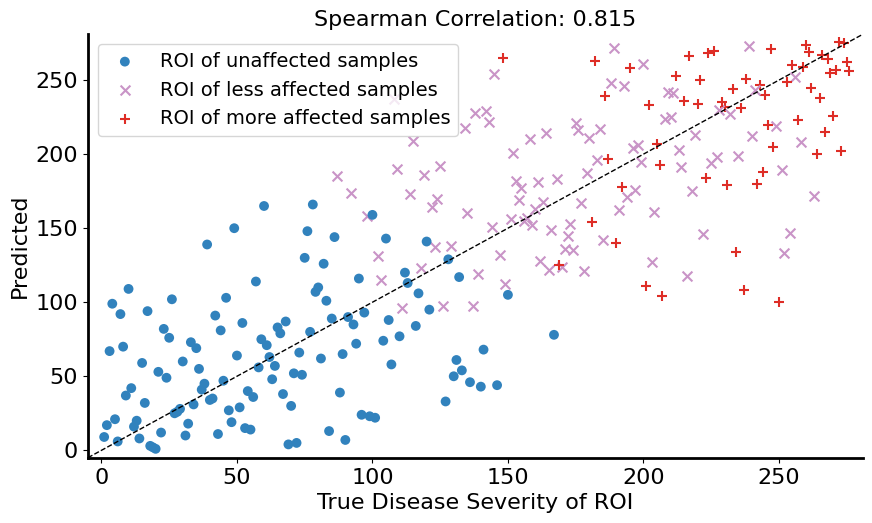

In [19]:
from scipy.stats import spearmanr
from scipy.stats import rankdata

result_path = '/ewsc/wuqitian/analysis_pred_data/region_time_prediction/'
file_path = result_path + f'lumen_rank_true.npy'
y_true = np.load(file_path)
file_path = result_path + f'lumen_rank_ours-MLP-pred-gene-no-image.npy'
y_pred = np.load(file_path)

samples = ['VUILD48LA2', 'THD0008', 'VUHD113', 'VUILD91MA', 'VUILD78LA', 'VUILD102MA']
states = ['Less Affected', 'Unaffected', 'Unaffected', 'More Affected', 'Less Affected', 'More Affected']

colors = {'Unaffected': '#3182bd', 'Less Affected': '#c994c7', 'More Affected': '#de2d26'}
markers = {'Unaffected': 'o', 'Less Affected': 'x', 'More Affected': '+'}
labels = {'Unaffected': 'ROI of unaffected samples', 
          'Less Affected': 'ROI of less affected samples',
         'More Affected': 'ROI of more affected samples'}

sample_lumen_idx = []
offset, total_num = 0, y_true.shape[0]
for sample in samples:
    file_path = os.path.join(dir_path, sample) + '.h5ad'
    adata = sc.read(file_path)
    lumen_rank = adata.obs['lumen_rank'].to_numpy()
    lumen_num = np.unique(lumen_rank).shape[0] - 1
    mask = np.zeros((total_num, ), dtype=bool)
    mask[offset:offset+lumen_num] = True
    sample_lumen_idx += [mask]
    offset += lumen_num

sample_mask = np.concatenate(sample_lumen_idx, axis=0)
y_true, y_pred = rankdata(y_true), rankdata(y_pred)

fig, ax = plt.subplots(1, 1, figsize=(10, 5.5), gridspec_kw={'wspace': 0.3})

for i, (lumen_idx, state) in enumerate(zip(sample_lumen_idx, states)):
    if i in [2, 4, 5]:
        ax.scatter(y_true[lumen_idx], y_pred[lumen_idx], c=colors[state], marker=markers[state], edgecolors='none', s=50.0, label=labels[state])
    else:
        ax.scatter(y_true[lumen_idx], y_pred[lumen_idx], c=colors[state], marker=markers[state], edgecolors='none', s=50.0)
corr, _ = spearmanr(y_true, y_pred)
ax.set_title(f'Spearman Correlation: {corr:.3f}', fontsize=16)
ax.set_xlabel(f'True Disease Severity of ROI', fontsize=16)
ax.set_ylabel(f'Predicted', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim(-5, y_true.shape[0]+5)
ax.set_ylim(-5, y_true.shape[0]+5)
ax.set_xticks([0, 50, 100, 150, 200, 250])
ax.set_yticks([0, 50, 100, 150, 200, 250])
ax.plot([-5, y_true.shape[0]+5], [-5, y_true.shape[0]+5], color="k", linestyle="--", linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.legend(loc='upper left', bbox_to_anchor=(0., 1), frameon=True, ncols=1, fontsize=14)

plt.tight_layout()
plt.savefig('../../figure/pred_lung_region_time_corr.pdf')
plt.show()

(36, 1024)


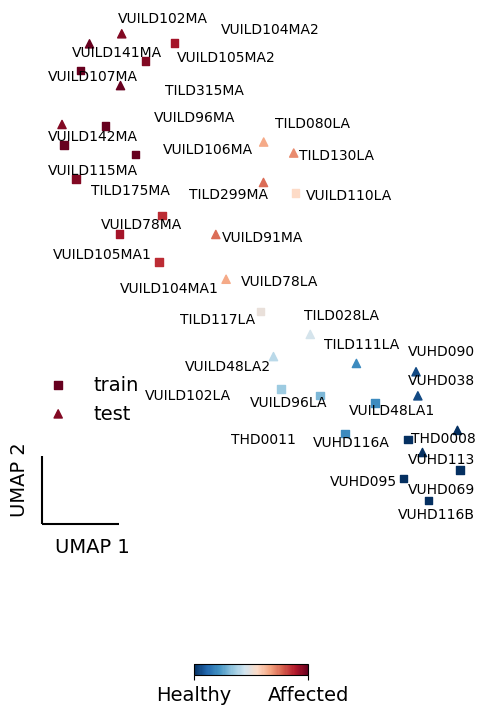

In [5]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
import pickle 

colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
n_bins = 100 
cmap = LinearSegmentedColormap.from_list('custom_green', colors, N=n_bins)

res_path = '/ewsc/wuqitian/analysis_pred_data/embs_attns'

train_samples = ['VUILD106MA', 'THD0011', 'VUHD116A', 'VUHD116B', 'VUHD069', 'TILD117LA', 'VUILD110LA', 'VUILD96LA', 'VUILD102LA',
                'VUILD48LA1', 'VUILD78MA', 'VUILD115MA', 'VUILD104MA1', 'VUILD105MA1', 'VUILD96MA', 'VUILD105MA2',
                'VUILD107MA', 'TILD175MA', 'VUILD104MA2', 'VUHD095']
test_samples = ['VUILD102MA', 'VUILD48LA2', 'THD0008', 'VUILD91MA', 'VUILD78LA', 'VUHD113',
                'TILD315MA', 'TILD299MA', 'VUILD142MA', 'VUILD141MA', 'TILD028LA', 'TILD111LA', 'TILD080LA', 'TILD130LA',
                'VUHD090', 'VUHD038']

sample_embs_merge = []
sample_merge = []
patho_merge = []
split_merge = []
for sample in train_samples+test_samples:
    file_path = os.path.join(res_path, sample) + '.h5ad'
    adata = sc.read(file_path)
    sample_embs_merge += [adata.obsm['embs_ours'].mean(0)]
    sample_merge += [sample]
    patho_merge += [adata.obs['percent_pathology'][0]]
    split_merge += ['train'] if sample in train_samples else ['test']
sample_embs_merge = np.array(sample_embs_merge, dtype=int)
sample_merge = np.array(sample_merge)
patho_merge = np.array(patho_merge)
split_merge = np.array(split_merge)

print(sample_embs_merge.shape)

sample_embs_norm = sample_embs_merge / np.linalg.norm(sample_embs_merge)
scaler = StandardScaler()
patho_merge_scale = scaler.fit_transform(patho_merge.reshape(-1, 1))

with open(os.path.join(res_path, 'slide_umap_embs.pkl'), 'rb') as f:
    X_umap = pickle.load(f)

X_umap[:, 0], X_umap[:, 1] = X_umap[:, 0], -X_umap[:, 1]

fig, ax = plt.subplots(figsize=(5, 8))
tr_mask = split_merge == 'train'
scatter = plt.scatter(X_umap[tr_mask, 0], X_umap[tr_mask, 1], c=patho_merge[tr_mask], cmap=cmap, marker='s', s=30, alpha=1.0, label='train')
te_mask = split_merge == 'test'
scatter = plt.scatter(X_umap[te_mask, 0], X_umap[te_mask, 1], c=patho_merge[te_mask], cmap=cmap, marker='^', s=35, alpha=1.0, label='test')
cbar = plt.colorbar(scatter, location='bottom', orientation='horizontal', shrink=0.25, aspect=10)
plt.legend(loc='lower left', bbox_to_anchor=(0., 0.2), frameon=False, ncols=1, fontsize=14)

texts = []
for i, sample in enumerate(sample_merge):
    texts.append(plt.annotate(sample, (X_umap[i, 0], X_umap[i, 1]), ha='center', va='center', fontsize=10))
adjust_text(texts, avoid_self=True, expand=(1, 1.5))

cbar.set_ticks([0, 100])
cbar.set_ticklabels(['Healthy', 'Affected'], fontsize=14)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
plt.hlines(y=ylim[0], xmin=xlim[0], xmax=xlim[0]+1.2, colors='black', linestyles='-')
plt.vlines(x=xlim[0], ymin=ylim[0], ymax=ylim[0]+1.2, colors='black', linestyles='-')
plt.text(xlim[0]+0.2, ylim[0]-0.5, 'UMAP 1', fontsize=14)
plt.text(xlim[0]-0.5, ylim[0]+0.2, 'UMAP 2', fontsize=14, rotation=90)

plt.grid(False)
plt.axis('off')

plt.tight_layout()
plt.savefig('../../figure/pred_lung_sample_umap.pdf')
plt.show()